# Imports

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
# LIMIT GPU MEMORY TAKEN UP BY THE NOTEBOOK
# you can specify the fraction of the AVAILABLE GPU memory that will be
# pre-allocated (jax default is .9)

import os
os.environ['XLA_PYTHON_CLIENT_MEM_FRACTION'] = '.45'
# #os.environ['XLA_PYTHON_CLIENT_PREALLOCATE'] = 'false'

# #use another GPU if the default one is occupied
# os.environ['CUDA_VISIBLE_DEVICES'] = '1'

#import utils from the parent folder
import sys
sys.path.append('../')

In [31]:
#no warnings about floating precision
import warnings
warnings.filterwarnings('ignore')

import pickle

########## IMPORT JAX ECOSYSTEM ##########
import jax
import jax.numpy as np
from jax.random import split, PRNGKey

jax.config.update('jax_debug_nans', True)

import optax
import equinox as eqx

import jax_md
import jax_md.dataclasses as jdc

########## IMPORT JAX-MORPH FUNCTIONS ##########
################################################

from jax_morph.simulation import simulation, sim_trajectory
from jax_morph.optimization.losses import loss

from jax_morph.visualization import draw_circles_ctype, draw_circles_chem, draw_circles_divrate


########## IMPORT PLOTTING UTILITIES ##########
###############################################
import matplotlib.pyplot as plt
plt.rcParams.update({'font.size': 20})


########## IMPORT OTHER UTILITIES ##########
############################################
from tqdm import tqdm, trange
from functools import partial
from collections import namedtuple

from alife_utils import default_params, build_sim_from_params, run_optimization, mask_metric, make_gif

# Set Parameters

In [7]:
key = PRNGKey(0)


key, init_key = split(key)
Dparams, Dtrain_params = default_params(init_key, 3)
Dparams['ncells_add']=129
Dparams['hidden_state_size']=64
Dparams['hid_hidden']=[128]

In [8]:
key, subkey = split(key)

sim = build_sim_from_params(Dparams, Dtrain_params, subkey)

In [9]:
def v_mask(pos):
    '''
    Constrain cell growth in a V shape.
    '''
    return (pos[:,1]+1.5 > .5*np.abs(pos[:,0])) * (pos[:,1]+1.5 < 3.5+.5*np.abs(pos[:,0])) * (pos[:,1]>0.)


v_metric = mask_metric(v_mask)

## One optimization

Random hempirical facts:
- averaging over more than 8 or 16 simulation seems to impaire learning (?)

In [10]:
EPOCHS = 500
EPISODES_PER_UPDATE = 4
EPISODES_PER_EVAL = 64

#LEARNING_RATE = 1e-3
LEARNING_RATE = optax.piecewise_constant_schedule(1e-3, {150: .1})

METRIC_FN = v_metric

SAVE_EVERY = 100

key, train_key = split(key)
loss_t, params_t, _ = run_optimization(train_key,
                                       sim,
                                       METRIC_FN,
                                       metric_type='reward',
                                       epochs=EPOCHS,
                                       episodes_per_update=EPISODES_PER_UPDATE,
                                       episodes_per_eval=EPISODES_PER_EVAL,
                                       learning_rate=LEARNING_RATE,
                                       save_every=SAVE_EVERY,
                                       )


Loss: 71.3947:  41%|██████████▌               | 203/500 [06:48<09:58,  2.01s/it]

Interrupted


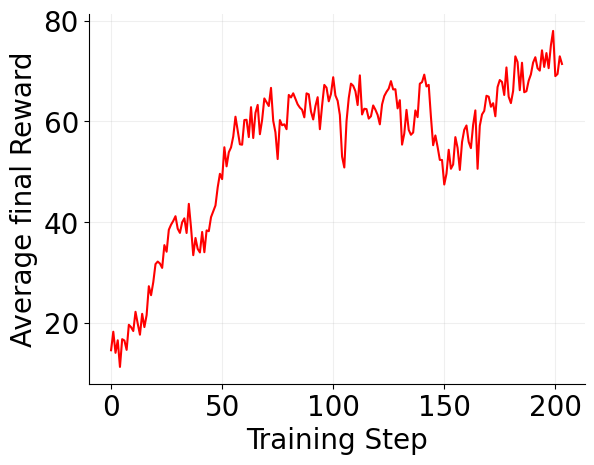

In [11]:
plt.plot(loss_t, 'r')

plt.grid(alpha=.2)

plt.xlabel('Training Step')
plt.ylabel('Average final Reward')

plt.gca().spines['right'].set_visible(False)
plt.gca().spines['top'].set_visible(False)

#plt.savefig('figs/reward_Vshape.png', dpi=300, bbox_inches='tight')

In [132]:
# Log = namedtuple('Log', ['loss_t', 'params_t', 'init_params', 'train_params', 'save_every', 'epochs', 'episodes_per_update', 'episodes_per_eval', 'learning_rate'])

# with open('log_opt_Vshape.pkl', 'wb') as f:
#     pickle.dump(Log(loss_t, params_t, sim.params, sim.train_params, SAVE_EVERY, EPOCHS, EPISODES_PER_UPDATE, EPISODES_PER_EVAL, {0:1e-3, 200:1e-4}), f)

In [81]:
# with open('log_opt_Vshape.pkl', 'rb') as f:
#     log = pickle.load(f)

# Analyze final states

## Initial params

In [123]:
NCELLS_ADD = sim.params['ncells_add']

key, subkey = split(key)

#forward pass - simulation
sim_init, sim_step = simulation(sim.fstep, sim.params, sim.fspace)
fstate, _ = sim_trajectory(sim.istate, sim_init, sim_step, ncells_add=NCELLS_ADD, key=subkey)

print(METRIC_FN(fstate))

19.526619


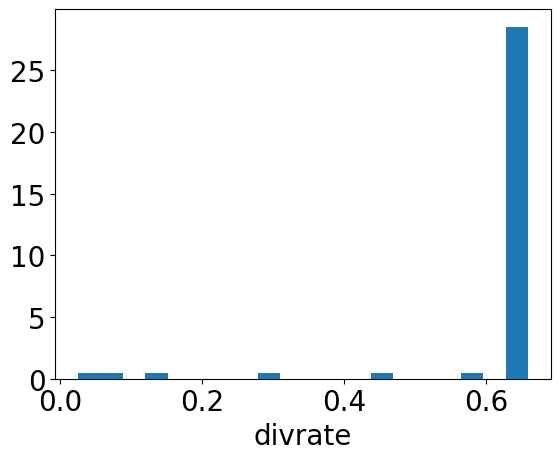

In [124]:
plt.hist(fstate.divrate.tolist(),20,density=True);
plt.xlabel('divrate');

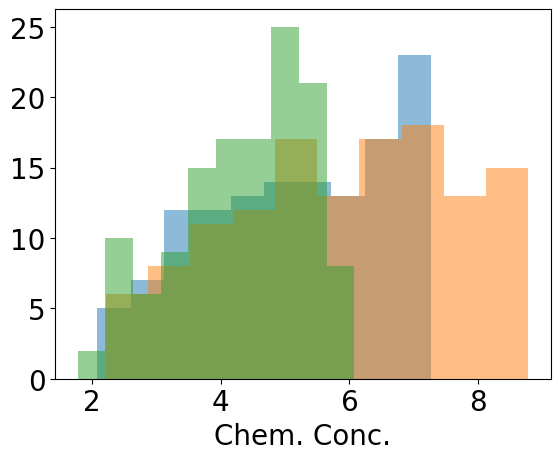

In [125]:
for chem in fstate.chemical.T.tolist():
    plt.hist(chem, alpha=.5);

plt.xlabel('Chem. Conc.');

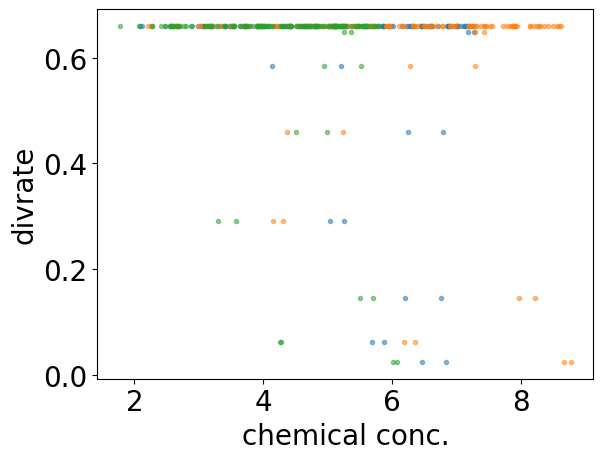

In [126]:
yy = fstate.divrate.tolist()

for chem in fstate.chemical.T.tolist():
    plt.plot(chem, yy, '.', alpha=.5)

plt.ylabel('divrate')
plt.xlabel('chemical conc.');

#plt.legend();

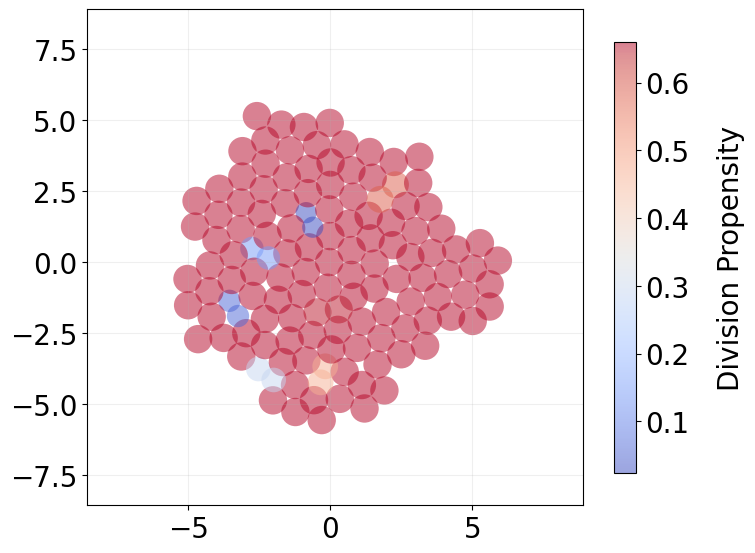

In [127]:
draw_circles_divrate(fstate, grid=True);

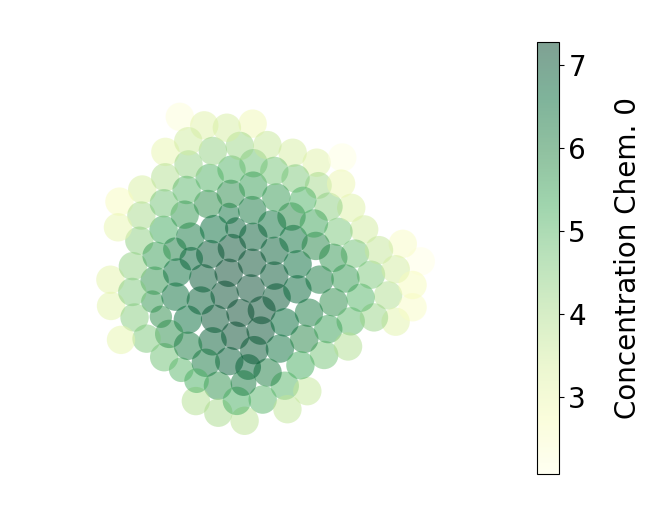

In [128]:
draw_circles_chem(fstate);

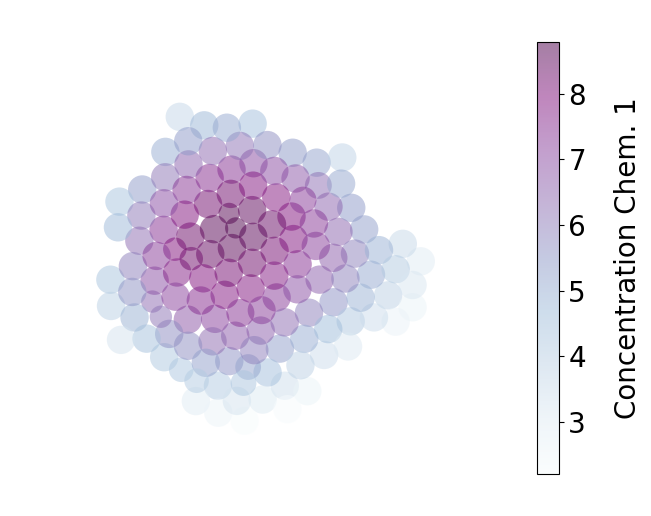

In [129]:
draw_circles_chem(fstate,1);

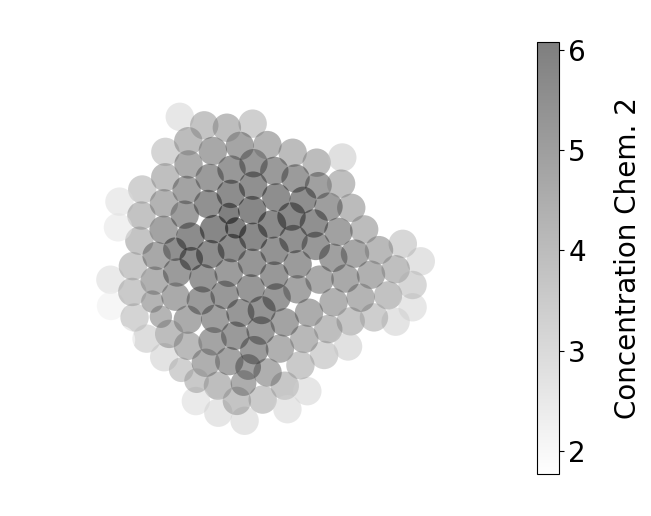

In [130]:
draw_circles_chem(fstate,2,cm=plt.cm.gray_r);

## Trained params

In [12]:
# merge params dicts
all_params = eqx.combine(params_t[-1], sim.params)

NCELLS_ADD = sim.params['ncells_add']

key, subkey = split(key)

#forward pass - simulation
sim_init, sim_step = simulation(sim.fstep, all_params, sim.fspace)
fstate, _ = sim_trajectory(sim.istate, sim_init, sim_step, ncells_add=NCELLS_ADD, key=subkey)


print('Final state metric:\t' + str(METRIC_FN(fstate)))

Final state metric:	72.46052


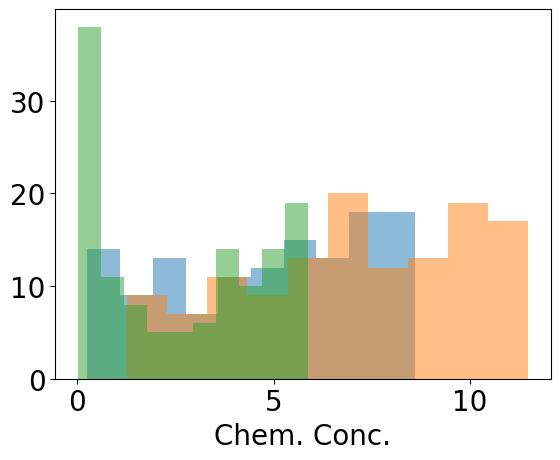

In [13]:
for chem in fstate.chemical.T.tolist():
    plt.hist(chem, alpha=.5);

plt.xlabel('Chem. Conc.');

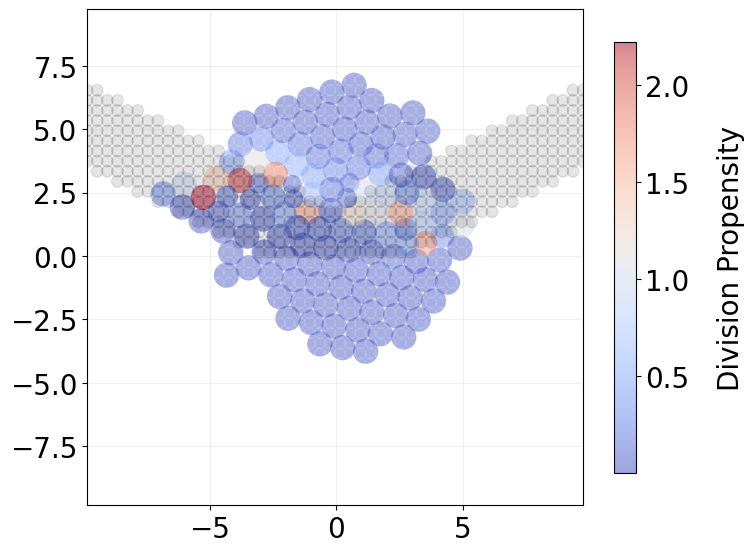

In [14]:
draw_circles_divrate(fstate, grid=True);



mask_fn = v_mask

xlim = plt.gca().get_xlim()

xx, yy = np.meshgrid(np.linspace(*xlim,50),np.linspace(*xlim,50))

pos = np.vstack((xx.flatten(),yy.flatten())).T

#scatter pos colored by V_mask value as heatmap
plt.scatter(pos[:,0], pos[:,1], c=mask_fn(pos), cmap=plt.cm.gray_r, s=70, alpha=.1);

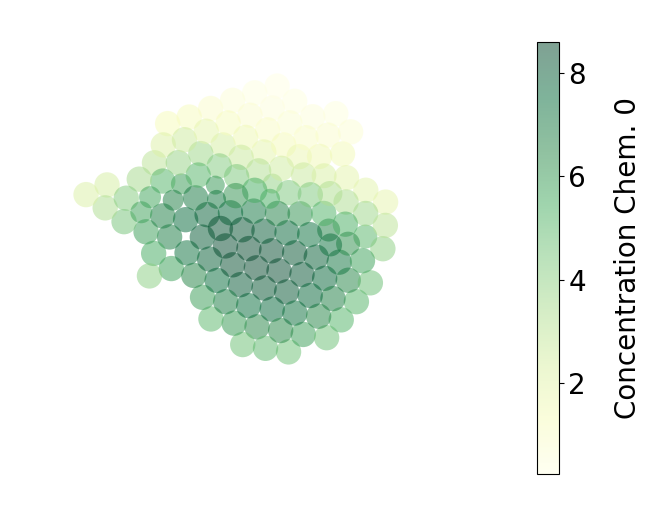

In [15]:
draw_circles_chem(fstate);

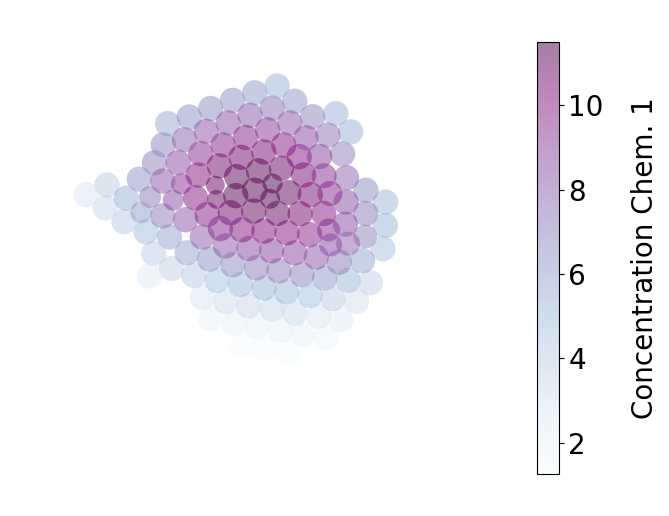

In [16]:
draw_circles_chem(fstate,1);

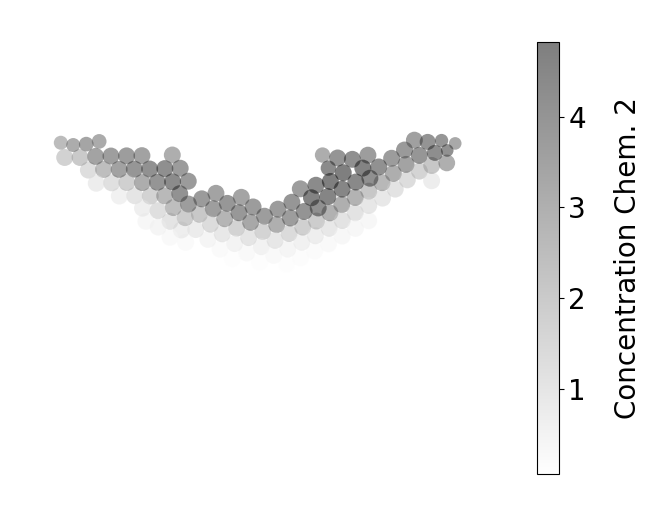

In [115]:
draw_circles_chem(fstate,2,cm=plt.cm.gray_r);

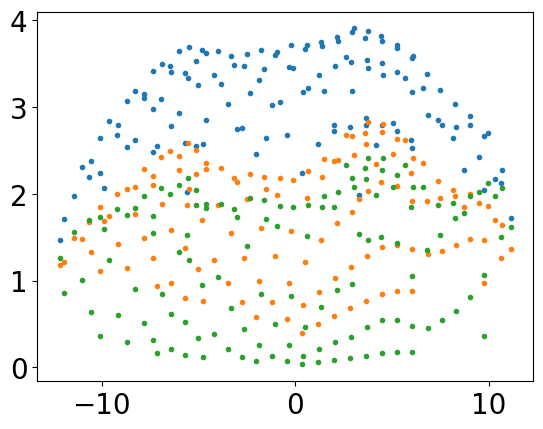

In [116]:
#smax = params_t[-1]['sec_max']
smax = sim.params['sec_max']

for i, c in enumerate(fstate.chemical.T):
    plt.plot(fstate.position[:,0], c/smax[i], '.')

# plt.plot(fstate.position[:,0], fstate.chemical[:,0]/smax[0], '.')
# plt.plot(fstate.position[:,0], fstate.chemical[:,1]/smax[1], '.')
# plt.plot(fstate.position[:,0], fstate.chemical[:,2]/smax[2], '.')

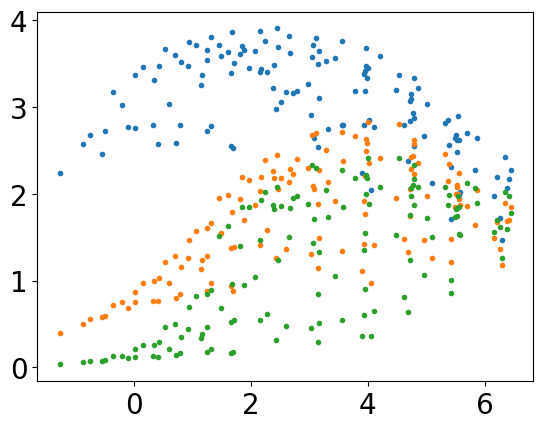

In [117]:
#smax = params_t[-1]['sec_max']
smax = sim.params['sec_max']


for i, c in enumerate(fstate.chemical.T):
    plt.plot(fstate.position[:,1], c/smax[i], '.')

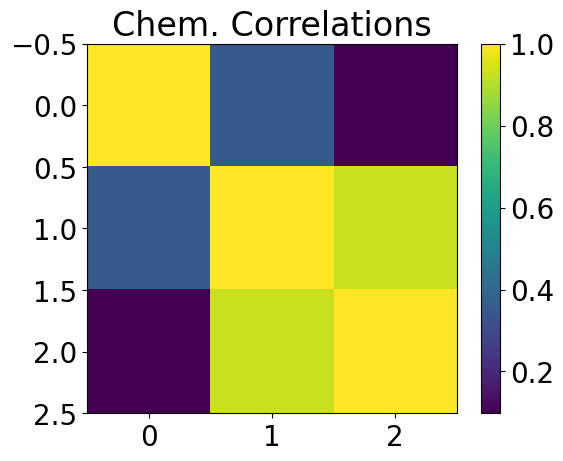

In [118]:
plt.imshow(np.corrcoef(fstate.chemical.T))
plt.colorbar();

plt.title('Chem. Correlations');

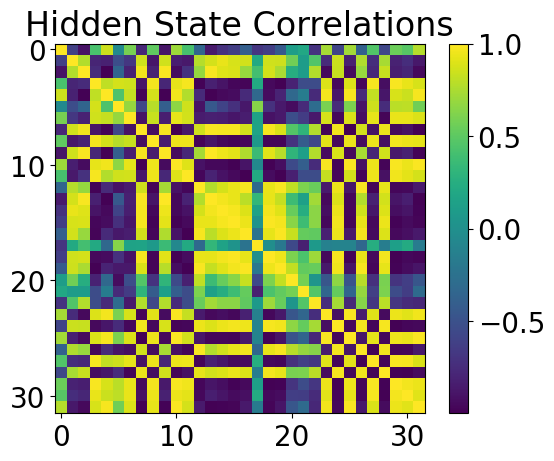

In [119]:
plt.imshow(np.corrcoef(fstate.hidden_state.T))
plt.colorbar();

plt.title('Hidden State Correlations');

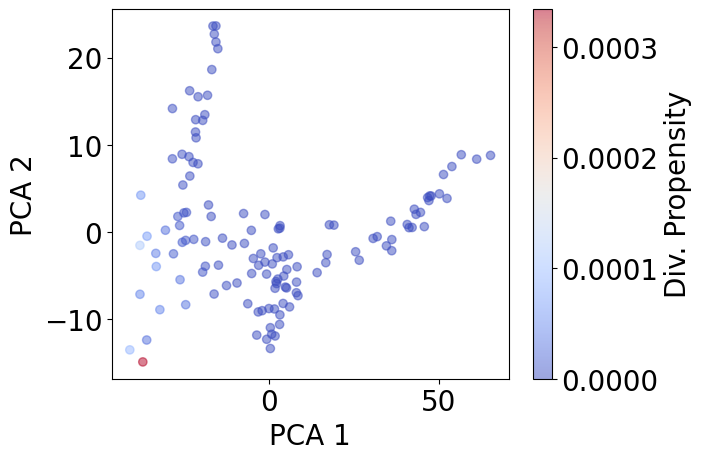

In [120]:
#transform hidden states with pca to 2d
from sklearn.decomposition import PCA

pca = PCA(n_components=2)

# pca_hidden = pca.fit_transform(np.log(fstate.hidden_state + 1e-40))
pca_hidden = pca.fit_transform(fstate.hidden_state)


plt.scatter(pca_hidden[:,0], pca_hidden[:,1], c=fstate.divrate, cmap='coolwarm', alpha=.5)
plt.xlabel('PCA 1')
plt.ylabel('PCA 2')

plt.colorbar(label='Div. Propensity');

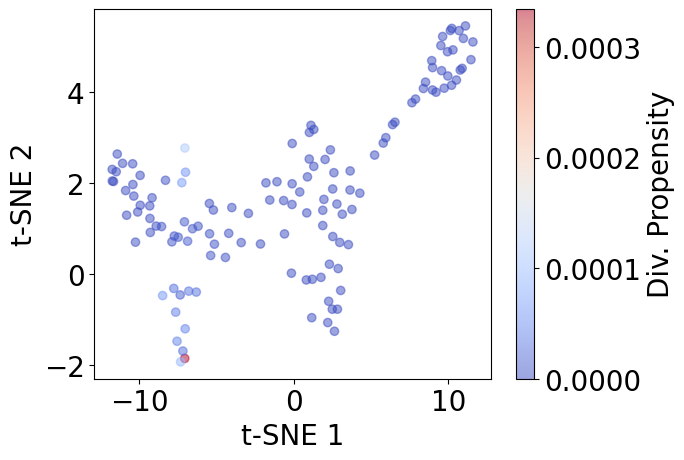

In [121]:
#transform hidden states with t-sne to 2d
from sklearn.manifold import TSNE

tsne = TSNE(n_components=2)

# tsne_hidden = tsne.fit_transform(np.log(fstate.hidden_state + 1e-40))
tsne_hidden = tsne.fit_transform(fstate.hidden_state)


plt.scatter(tsne_hidden[:,0], tsne_hidden[:,1], c=fstate.divrate, cmap='coolwarm', alpha=.5)
plt.xlabel('t-SNE 1')
plt.ylabel('t-SNE 2')

plt.colorbar(label='Div. Propensity');


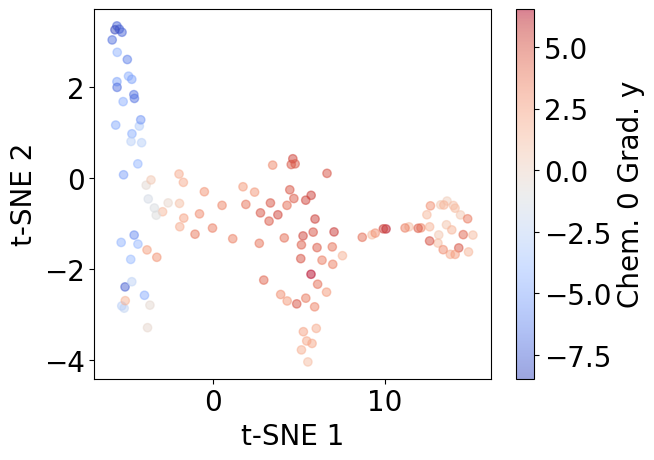

In [122]:
#transform hidden states with t-sne to 2d
from sklearn.manifold import TSNE

tsne = TSNE(n_components=2)

# tsne_hidden = tsne.fit_transform(np.log(fstate.hidden_state + 1e-40))
tsne_hidden = tsne.fit_transform(fstate.hidden_state)


plt.scatter(tsne_hidden[:,0], tsne_hidden[:,1], c=fstate.chemgrad[:,7], cmap='coolwarm', alpha=.5)
plt.xlabel('t-SNE 1')
plt.ylabel('t-SNE 2')

plt.colorbar(label='Chem. 0 Grad. y');


# Regeneration

## Kill functions


In [23]:
def kill_random(key, state, kill_rate=.3):
    '''Kill cells randomly'''

    ncells = int((state.celltype > 0).sum())
    nkill = int(ncells * kill_rate)

    #randomly select cells to kill
    kill_idx = jax.random.choice(key, ncells, shape=(nkill,), replace=False)

    #get only cells not in kill_idx
    new_fields = {}
    for field in jdc.fields(state):

        value = getattr(state, field.name)

        if 'key' == field.name:
            new_fields[field.name] = state.key
        else:
            new_fields[field.name] = np.delete(value, kill_idx, axis=0)


    state = type(state)(**new_fields)

    return state


def kill_line(state, m=10, b=0):
    '''Kill cells below line y=mx+b'''

    alive = state.celltype > 0
    pos = state.position[alive]

    #select cells to kill
    kill_idx = np.argwhere(pos[:,1] < m*pos[:,0] + b).flatten()

    #get only cells not in kill_idx
    new_fields = {}
    for field in jdc.fields(state):

        value = getattr(state, field.name)

        if 'key' == field.name:
            new_fields[field.name] = state.key
        else:
            new_fields[field.name] = np.delete(value, kill_idx, axis=0)


    state = type(state)(**new_fields)

    return state


## Trained params

In [26]:
# merge params dicts
all_params = eqx.combine(params_t[-1], sim.params)

NCELLS_ADD = sim.params['ncells_add']

key, subkey = split(key)

#forward pass - simulation
sim_init, sim_step = simulation(sim.fstep, all_params, sim.fspace)
fstate, _ = sim_trajectory(sim.istate, sim_init, sim_step, ncells_add=NCELLS_ADD, key=subkey)


print('Final state metric:\t' + str(METRIC_FN(fstate)))

Final state metric:	215.54086


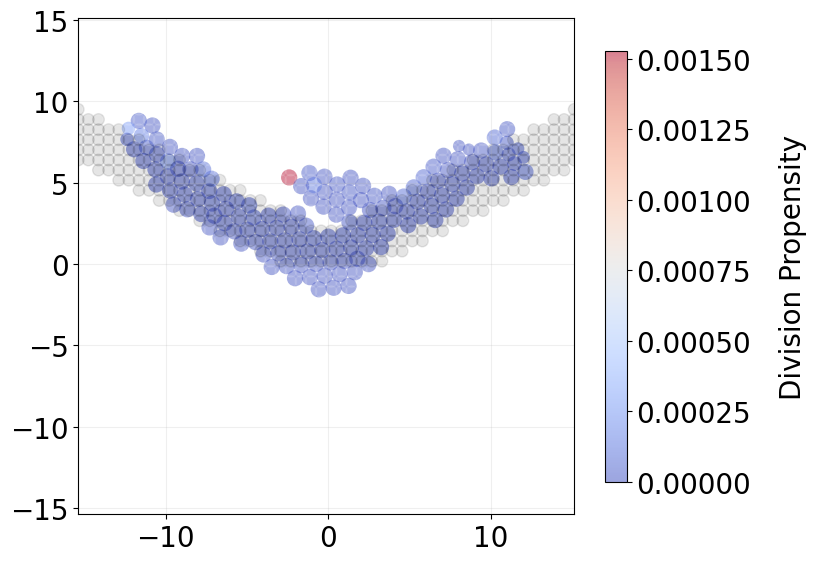

In [27]:
draw_circles_divrate(fstate, grid=True);


mask_fn = v_mask

xlim = plt.gca().get_xlim()

xx, yy = np.meshgrid(np.linspace(*xlim,50),np.linspace(*xlim,50))

pos = np.vstack((xx.flatten(),yy.flatten())).T

#scatter pos colored by V_mask value as heatmap
plt.scatter(pos[:,0], pos[:,1], c=mask_fn(pos), cmap=plt.cm.gray_r, s=70, alpha=.1);

## Kill fraction (random)

In [28]:
KILL_RATE = .7
N_CELLS = int((fstate.celltype > 0).sum())
N_KILL = int(KILL_RATE * N_CELLS)

kill_state = kill_random(key, fstate, kill_rate=KILL_RATE)

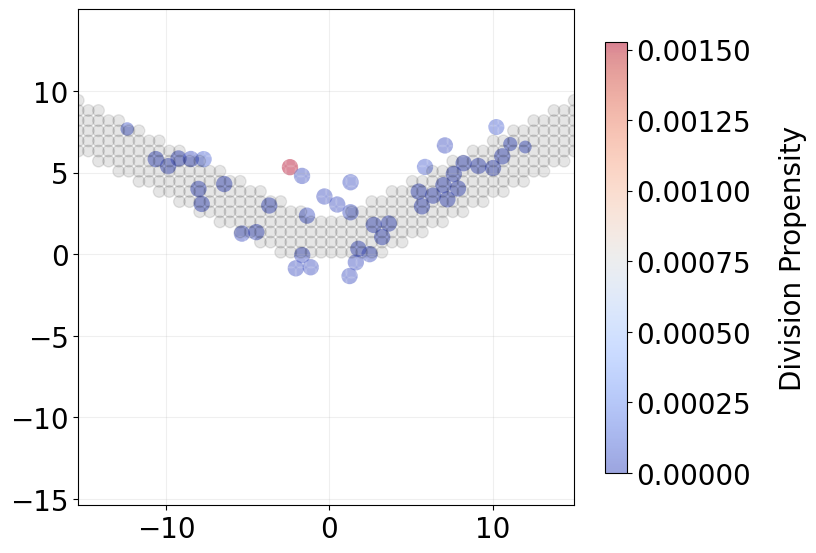

In [29]:
draw_circles_divrate(kill_state, grid=True);


mask_fn = v_mask

xlim = plt.gca().get_xlim()

xx, yy = np.meshgrid(np.linspace(*xlim,50),np.linspace(*xlim,50))

pos = np.vstack((xx.flatten(),yy.flatten())).T

#scatter pos colored by V_mask value as heatmap
plt.scatter(pos[:,0], pos[:,1], c=mask_fn(pos), cmap=plt.cm.gray_r, s=70, alpha=.1);

In [30]:
# merge params dicts
all_params = eqx.combine(params_t[-1], sim.params)

NCELLS_ADD = N_KILL

key, subkey = split(key)

#forward pass - simulation
sim_init, sim_step = simulation(sim.fstep, all_params, sim.fspace)
regen_state, _ = sim_trajectory(kill_state, sim_init, sim_step, ncells_add=NCELLS_ADD, key=subkey)


print('Final state metric:\t' + str(METRIC_FN(regen_state)))

Final state metric:	173.48769


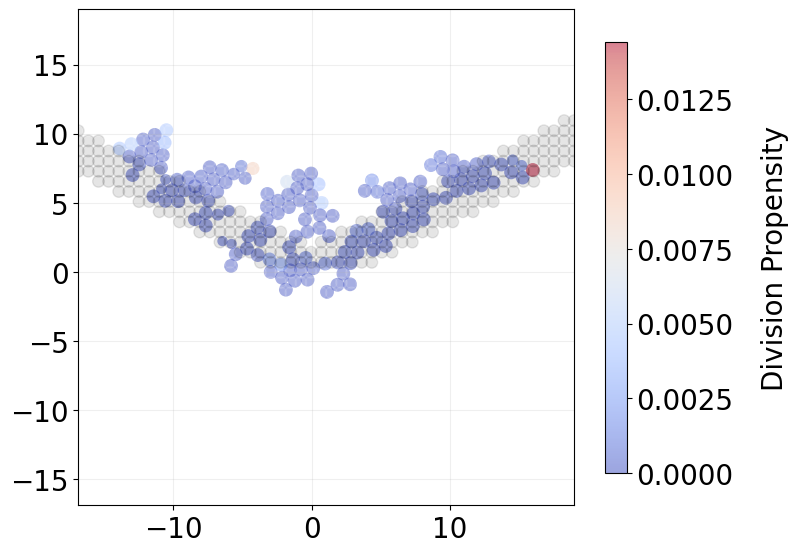

In [31]:
draw_circles_divrate(regen_state, grid=True);


mask_fn = v_mask

xlim = plt.gca().get_xlim()

xx, yy = np.meshgrid(np.linspace(*xlim,50),np.linspace(*xlim,50))

pos = np.vstack((xx.flatten(),yy.flatten())).T

#scatter pos colored by V_mask value as heatmap
plt.scatter(pos[:,0], pos[:,1], c=mask_fn(pos), cmap=plt.cm.gray_r, s=70, alpha=.1);

### Kill rate vs. Recovery

In [33]:
kill_rates = np.linspace(.0,.9,7)
n_avg = 15

N_CELLS = int((fstate.celltype > 0).sum())
n_kills = (kill_rates * N_CELLS).astype(int)
kill_rates = n_kills / N_CELLS #recalculate actual kill rates

all_params = eqx.combine(params_t[-1], sim.params)

log = {'kill_rates':kill_rates.tolist(), 'regen_metrics_avg':[], 'regen_metrics_std':[]}

for kr, nk in zip(kill_rates, n_kills):
    reps = []
    for i in tqdm(np.arange(n_avg), desc='kill rate: ' + str(kr)):

        key, subkey, subkey_reg = split(key, 3)

        kill_state = kill_random(subkey, fstate, kill_rate=kr)

        #forward pass - simulation
        sim_init, sim_step = simulation(sim.fstep, all_params, sim.fspace)
        regen_state, _ = sim_trajectory(kill_state, sim_init, sim_step, ncells_add=nk, key=subkey_reg)

        reps += [float(METRIC_FN(regen_state))]

    reps = np.array(reps)
    log['regen_metrics_avg'] += [float(np.mean(reps))]
    log['regen_metrics_std'] += [float(np.std(reps))]

kill rate: 0.9: 100%|███████████████████████████| 15/15 [00:38<00:00,  2.57s/it]


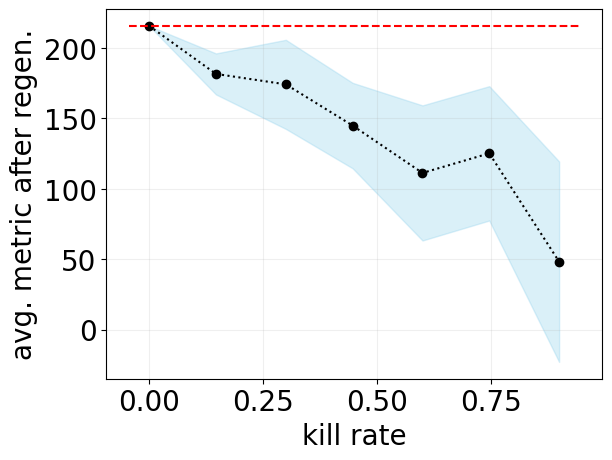

In [34]:
#plot results

#plt.errorbar(log['kill_rates'], log['regen_metrics_avg'], yerr=log['regen_metrics_std'], fmt='o-')
plt.plot(log['kill_rates'], log['regen_metrics_avg'], 'ko:')
plt.fill_between(log['kill_rates'], np.array(log['regen_metrics_avg']) - np.array(log['regen_metrics_std']), np.array(log['regen_metrics_avg']) + np.array(log['regen_metrics_std']), alpha=.3, color='skyblue')

plt.hlines(METRIC_FN(fstate), *plt.gca().get_xlim(), linestyles='dashed', color='r')

plt.xlabel('kill rate')
plt.ylabel('avg. metric after regen.')
plt.grid(alpha=.2)

## Kill below line

In [127]:
kill_state_line = kill_line(fstate)

N_KILL_LINE = int(fstate.celltype.shape[0]-kill_state_line.celltype.shape[0])

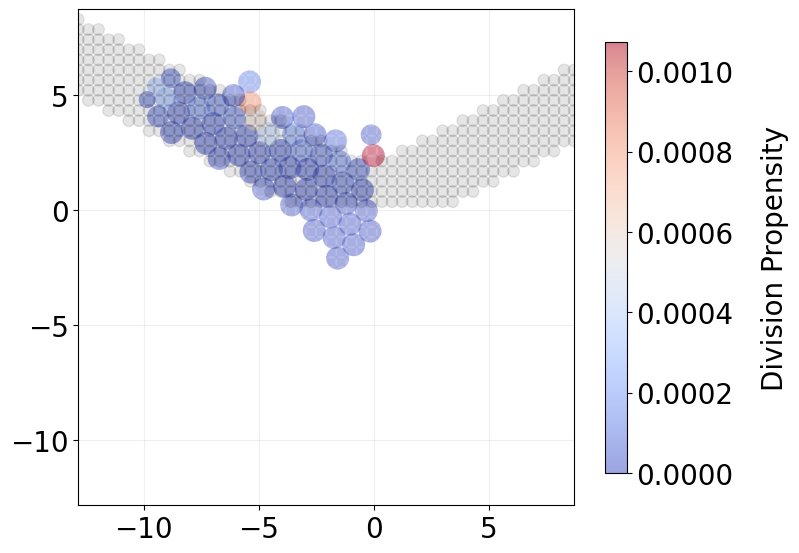

In [128]:
draw_circles_divrate(kill_state_line, grid=True);


mask_fn = v_mask

xlim = plt.gca().get_xlim()

xx, yy = np.meshgrid(np.linspace(*xlim,50),np.linspace(*xlim,50))

pos = np.vstack((xx.flatten(),yy.flatten())).T

#scatter pos colored by V_mask value as heatmap
plt.scatter(pos[:,0], pos[:,1], c=mask_fn(pos), cmap=plt.cm.gray_r, s=70, alpha=.1);

In [145]:
# merge params dicts
all_params = eqx.combine(params_t[-1], params)

NCELLS_ADD = N_KILL_LINE

key, subkey = split(key)

#forward pass - simulation
sim_init, sim_step = simulation(fstep, all_params, fspace)
regen_state_line, _ = sim_trajectory(kill_state_line, sim_init, sim_step, ncells_add=NCELLS_ADD, key=subkey)


print('Final state metric:\t' + str(METRIC_FN(regen_state_line)))

Final state metric:	-73.63049


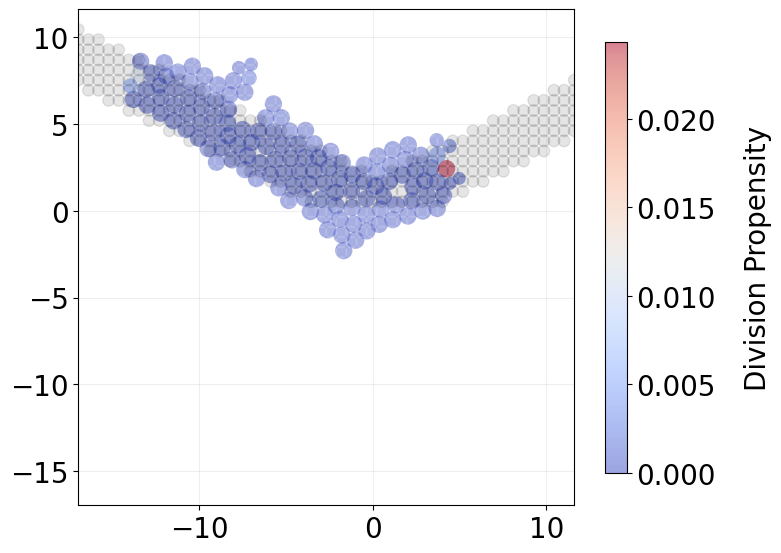

In [146]:
draw_circles_divrate(regen_state_line, grid=True);


mask_fn = v_mask

xlim = plt.gca().get_xlim()

xx, yy = np.meshgrid(np.linspace(*xlim,50),np.linspace(*xlim,50))

pos = np.vstack((xx.flatten(),yy.flatten())).T

#scatter pos colored by V_mask value as heatmap
plt.scatter(pos[:,0], pos[:,1], c=mask_fn(pos), cmap=plt.cm.gray_r, s=70, alpha=.1);

In [48]:
LogExperiment = namedtuple('LogExperiment', ['epochs', 'episodes_per_update', 'episodes_per_eval', 'learning_rate', 'sim', 'opt_runs'])

LogRep = namedtuple('LogRep', ['loss_t', 'params_t', 'grads_t'])


EPOCHS = 50
EPISODES_PER_UPDATE = 4
EPISODES_PER_EVAL = 100

LEARNING_RATE = 1e-3

METRIC_FN = v_metric


SAVE_EVERY = 100

log2 = LogExperiment(epochs=EPOCHS, 
                episodes_per_update=EPISODES_PER_UPDATE, 
                episodes_per_eval=EPISODES_PER_EVAL, 
                learning_rate=LEARNING_RATE, 
                sim=sim, 
                opt_runs={}
                )



hsize = [4, 8, 16, 32, 64]

for HID_SIZE in hsize:

    Dparams['hidden_state_size'] = HID_SIZE
    Dparams['ncells_add'] = 119


    key, subkey = split(key)
    sim = build_sim_from_params(Dparams, Dtrain_params, subkey)

    key, train_key = split(key)
    loss_t, params_t, _ = run_optimization(train_key,
                                            sim,
                                            METRIC_FN,
                                            metric_type='reward',
                                            epochs=EPOCHS,
                                            episodes_per_update=EPISODES_PER_UPDATE,
                                            episodes_per_eval=EPISODES_PER_EVAL,
                                            learning_rate=LEARNING_RATE,
                                            save_every=SAVE_EVERY
                                            )

    log2.opt_runs[HID_SIZE] = LogRep(loss_t=loss_t, params_t=params_t, grads_t=None)

Loss: 35.3516: 100%|████████████████████████████| 50/50 [01:05<00:00,  1.31s/it]


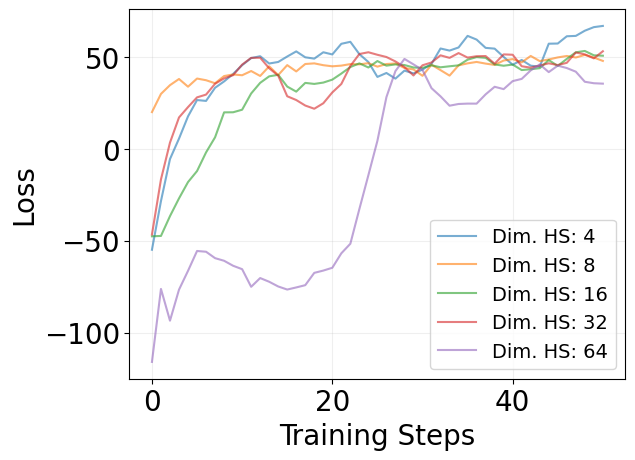

In [49]:
for hsize in sorted(log2.opt_runs.keys()):
    plt.plot(log2.opt_runs[hsize].loss_t, alpha=.6, label=f'Dim. HS: {hsize}')

plt.grid(alpha=.2)

plt.xlabel('Training Steps')
plt.ylabel('Reward');

plt.legend(fontsize=14);

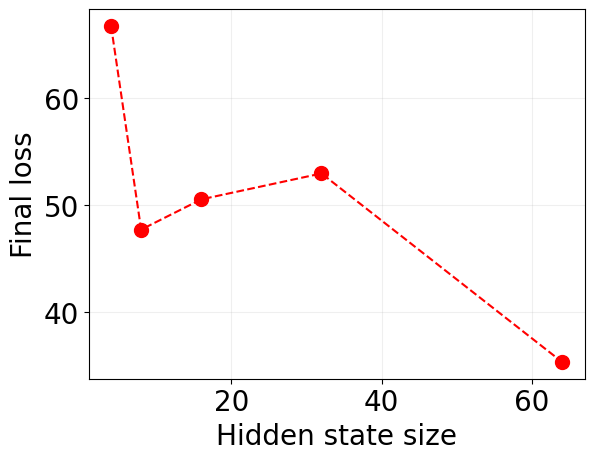

In [50]:
hsize = sorted(log2.opt_runs.keys())
flooses = [log2.opt_runs[hs].loss_t[-1] for hs in hsize]

plt.plot(hsize, flooses, 'o--', color='r', markersize=10)

plt.grid(alpha=.2)

plt.xlabel('Hidden state size')
plt.ylabel('Final reward');